In [1]:
!pip install pretrainedmodels
!pip install segmentation_models_pytorch

     |████████████████████████████████| 58 kB 2.4 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=7e02370054c4b2cebd7b374b9c208efdc7490a238d15001eacc72537448311b4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 66 kB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 244 kB 8.7 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=9f5e12e2320d4e09b14195fe6be96d55e118407be3cd681982a2dd2c9c2782a6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/p

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
import glob

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
import albumentations as A
import rasterio
from rasterio.windows import Window

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
set_seeds();

In [3]:
DATA_PATH = '../input/hubmap-kidney-segmentation/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(DEVICE)

import logging

logging.basicConfig(filename='log.log',
                    format='%(asctime)s - %(name)s - %(levelname)s -%(module)s:  %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S ',
                    level=logging.INFO)

cuda


In [4]:
# used for converting the decoded image to rle mask
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [5]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):

    def __init__(self, path, tiff_ids, transform,
                 window=256, overlap=32, threshold = 100, isvalid=False):
        self.path = pathlib.Path(path)
        self.tiff_ids = tiff_ids
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        self.isvalid = isvalid
        
        self.x, self.y, self.id = [], [], []
        self.build_slices()
        self.len = len(self.x)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, filename in enumerate(self.csv.index.values):
            if not filename in self.tiff_ids:
                continue
            
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            
            # print('Transform', filename)
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window, min_overlap=self.overlap)
                
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    # print(slc)
                    image = dataset.read([1,2,3],
                            window=Window.from_slices((x1,x2),(y1,y2)))
                    image = np.moveaxis(image, 0, -1)
                    
                    image = cv2.resize(image, (256, 256))
                    masks = cv2.resize(self.masks[-1][x1:x2,y1:y2], (256, 256))
                    
                    if self.isvalid:
                        self.slices.append([i,x1,x2,y1,y2])
                        self.x.append(image)
                        self.y.append(masks)
                        self.id.append(filename)
                    else:
                        if self.masks[-1][x1:x2,y1:y2].sum() >= self.threshold or (image>32).mean() > 0.99:
                            self.slices.append([i,x1,x2,y1,y2])
                            
                            self.x.append(image)
                            self.y.append(masks)
                            self.id.append(filename)
    
    # get data operation
    def __getitem__(self, index):
        image, mask = self.x[index], self.y[index]
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [6]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(False)
    
    pth = torch.load('../fcn_resnet50_coco-1167a1af.pth')
    for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
        del pth[key]
    
    model.load_state_dict(pth)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model


import functools
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import ResNet
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
from pretrainedmodels.models.torchvision_models import pretrained_settings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def preprocess_input(x, mean=None, std=None, input_space='RGB', input_range=None, **kwargs):

    if input_space == 'BGR':
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


class Model(nn.Module):

    def __init__(self):
        super().__init__()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


class Conv2dReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, use_batchnorm=True, **batchnorm_params):

        super().__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=not (use_batchnorm)),
            nn.ReLU(inplace=True),
        ]

        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels, **batchnorm_params))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class EncoderDecoder(Model):

    def __init__(self, encoder, decoder, activation):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if callable(activation) or activation is None:
            self.activation = activation
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError('Activation should be "sigmoid"/"softmax"/callable/None')

    def forward(self, x):
        """Sequentially pass `x` trough model`s `encoder` and `decoder` (return logits!)"""
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)`
        and apply activation function (if activation is not `None`) with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)
            if self.activation:
                x = self.activation(x)

        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            Conv2dReLU(in_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
            Conv2dReLU(out_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
        )

    def forward(self, x):
        x, skip = x
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x


class CenterBlock(DecoderBlock):

    def forward(self, x):
        return self.block(x)


class UnetDecoder(Model):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            use_batchnorm=True,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = CenterBlock(channels, channels, use_batchnorm=use_batchnorm)
        else:
            self.center = None

        in_channels = self.compute_channels(encoder_channels, decoder_channels)
        out_channels = decoder_channels

        self.layer1 = DecoderBlock(in_channels[0], out_channels[0], use_batchnorm=use_batchnorm)
        self.layer2 = DecoderBlock(in_channels[1], out_channels[1], use_batchnorm=use_batchnorm)
        self.layer3 = DecoderBlock(in_channels[2], out_channels[2], use_batchnorm=use_batchnorm)
        self.layer4 = DecoderBlock(in_channels[3], out_channels[3], use_batchnorm=use_batchnorm)
        self.layer5 = DecoderBlock(in_channels[4], out_channels[4], use_batchnorm=use_batchnorm)
        self.final_conv = nn.Conv2d(out_channels[4], final_channels, kernel_size=(1, 1))

        self.initialize()

    def compute_channels(self, encoder_channels, decoder_channels):
        channels = [
            encoder_channels[0] + encoder_channels[1],
            encoder_channels[2] + decoder_channels[0],
            encoder_channels[3] + decoder_channels[1],
            encoder_channels[4] + decoder_channels[2],
            0 + decoder_channels[3],
        ]
        return channels

    def forward(self, x):
        encoder_head = x[0]
        skips = x[1:]

        if self.center:
            encoder_head = self.center(encoder_head)

        x = self.layer1([encoder_head, skips[0]])
        x = self.layer2([x, skips[1]])
        x = self.layer3([x, skips[2]])
        x = self.layer4([x, skips[3]])
        x = self.layer5([x, None])
        x = self.final_conv(x)

        return x


class ResNetEncoder(ResNet):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pretrained = False
        del self.fc

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)

        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)

        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return [x4, x3, x2, x1, x0]

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop('fc.bias')
        state_dict.pop('fc.weight')
        super().load_state_dict(state_dict, **kwargs)


resnet_encoders = {
    'resnet18': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet18'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [2, 2, 2, 2],
        },
    },

    'resnet34': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet34'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet50': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet50'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet101': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet101'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 23, 3],
        },
    },

    'resnet152': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet152'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 8, 36, 3],
        },
    },
}

encoders = {}
encoders.update(resnet_encoders)

def get_encoder(name, encoder_weights=None):
    Encoder = encoders[name]['encoder']
    encoder = Encoder(**encoders[name]['params'])
    encoder.out_shapes = encoders[name]['out_shapes']

    if encoder_weights is not None:
        settings = encoders[name]['pretrained_settings'][encoder_weights]
        encoder.load_state_dict(model_zoo.load_url(settings['url']))

    return encoder


def get_encoder_names():
    return list(encoders.keys())


def get_preprocessing_fn(encoder_name, pretrained='imagenet'):
    settings = encoders[encoder_name]['pretrained_settings']

    if pretrained not in settings.keys():
        raise ValueError('Avaliable pretrained options {}'.format(settings.keys()))

    input_space = settings[pretrained].get('input_space')
    input_range = settings[pretrained].get('input_range')
    mean = settings[pretrained].get('mean')
    std = settings[pretrained].get('std')
    
    return functools.partial(preprocess_input, mean=mean, std=std, input_space=input_space, input_range=input_range)


class Unet(EncoderDecoder):
    """Unet_ is a fully convolution neural network for image semantic segmentation

    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        activation: activation function used in ``.predict(x)`` method for inference.
            One of [``sigmoid``, ``softmax``, callable, None]
        center: if ``True`` add ``Conv2dReLU`` block on encoder head (useful for VGG models)

    Returns:
        ``torch.nn.Module``: **Unet**

    .. _Unet:
        https://arxiv.org/pdf/1505.04597

    """

    def __init__(
            self,
            encoder_name='resnet34',
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            classes=1,
            activation='sigmoid',
            center=False,  # usefull for VGG models
    ):
        encoder = get_encoder(
            encoder_name,
            encoder_weights=encoder_weights
        )

        decoder = UnetDecoder(
            encoder_channels=encoder.out_shapes,
            decoder_channels=decoder_channels,
            final_channels=classes,
            use_batchnorm=decoder_use_batchnorm,
            center=center,
        )

        super().__init__(encoder, decoder, activation)

        self.name = 'u-{}'.format(encoder_name)


In [7]:
def train(model, train_loader, criterion, optimizer):
    losses = []
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, target, 1, False)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print('train, ', loss.item())
    return np.array(losses).mean()

def np_dice_score(probability, mask):
    p = probability.reshape(-1)
    t = mask.reshape(-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum() + t.sum()
    
    overlap = (p*t).sum()
    dice = 2*overlap/(uion+0.001)
    return dice

def validation(model, val_loader, criterion):
    val_probability, val_mask = [], []
    model.eval()
    with torch.no_grad():
        for image, target in val_loader:
            image, target = image.to(DEVICE), target.float().to(DEVICE)
            output = model(image)
            
            output_ny = output.sigmoid().data.cpu().numpy()
            target_np = target.data.cpu().numpy()
            
            val_probability.append(output_ny)
            val_mask.append(target_np)
            
    val_probability = np.concatenate(val_probability)
    val_mask = np.concatenate(val_mask)
    
    return np_dice_score(val_probability, val_mask)
    

In [8]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        
        return 1 - dc

bce_fn = nn.BCEWithLogitsLoss()
# bce_fn = nn.BCELoss()
dice_fn = SoftDiceLoss()
    
def loss_fn(y_pred, y_true, ratio=0.8, hard=False):
    bce = bce_fn(y_pred, y_true)
    if hard:
        dice = dice_fn((y_pred.sigmoid()).float() > 0.5, y_true)
    else:
        dice = dice_fn(y_pred.sigmoid(), y_true)
    return ratio*bce + (1-ratio)*dice


In [9]:
EPOCHES = 5
BATCH_SIZE = 8

WINDOW=1024
MIN_OVERLAP=40
NEW_SIZE=256

train_trfm = A.Compose([
    # A.RandomCrop(NEW_SIZE*3, NEW_SIZE*3),
    A.Resize(NEW_SIZE, NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        A.ColorJitter(brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        ], p=0.3),
#     A.OneOf([
#         A.OpticalDistortion(p=0.5),
#         A.GridDistortion(p=0.5),
#         A.IAAPiecewiseAffine(p=0.5),
#     ], p=0.3),
#     A.ShiftScaleRotate(),
])

val_trfm = A.Compose([
    # A.CenterCrop(NEW_SIZE, NEW_SIZE),
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
#     A.OneOf([
#         A.RandomContrast(),
#         A.RandomGamma(),
#         A.RandomBrightness(),
#         A.ColorJitter(brightness=0.07, contrast=0.07,
#                    saturation=0.1, hue=0.1, always_apply=False, p=0.3),
#         ], p=0.3),
#     A.OneOf([
#         A.OpticalDistortion(p=0.5),
#         A.GridDistortion(p=0.5),
#         A.IAAPiecewiseAffine(p=0.5),
#     ], p=0.3),
#     A.ShiftScaleRotate(),
])

# 每个file单独做一个验证集
tiff_ids = np.array([x.split('/')[-1][:-5] for x in glob.glob('../input/hubmap-kidney-segmentation/train/*.tiff')])
skf = KFold(n_splits=8)

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(tiff_ids, tiff_ids)):
    print(tiff_ids[val_idx])
    
    # break
    train_ds = HubDataset(DATA_PATH, tiff_ids[train_idx], window=WINDOW, overlap=MIN_OVERLAP, 
                          threshold=100, transform=train_trfm)
    valid_ds = HubDataset(DATA_PATH, tiff_ids[val_idx], window=WINDOW, overlap=MIN_OVERLAP, 
                          threshold=100, transform=val_trfm, isvalid=False)

    print(len(train_ds), len(valid_ds))
    
    # define training and validation data loaders
    train_loader = D.DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)

    val_loader = D.DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=12)
    
    # model = get_model()
    # model = Unet(encoder_name="resnet34",classes=1,activation=None)
   
    import segmentation_models_pytorch as smp

    model = smp.Unet(
        encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
        in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
        classes=1,                      # model output channels (number of classes in your dataset)
    )

    model.to(DEVICE);
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    # lr_step = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 2)
    lr_step = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
    
    header = r'''
            Train | Valid
    Epoch |  Loss |  Dice (Best) | Time
    '''
    print(header)
    #          Epoch         metrics            time
    raw_line = '{:6d}' + '\u2502{:7.4f}'*3 + '\u2502{:6.2f}'
    
    best_dice = 0
    for epoch in range(1, EPOCHES+1):
        start_time = time.time()
        model.train()
        train_loss = train(model, train_loader, loss_fn, optimizer)
        val_dice = validation(model, val_loader, loss_fn)
        lr_step.step(val_dice)

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'fold_{0}.pth'.format(fold_idx))
        
        logging.info(raw_line.format(epoch, train_loss, val_dice, best_dice, (time.time()-start_time)/60**1))
        
    
    del train_loader, val_loader, train_ds, valid_ds
    gc.collect();
    
    break

['095bf7a1f']
4399 1018


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth




            Train | Valid
    Epoch |  Loss |  Dice (Best) | Time
    


In [15]:

model.load_state_dict(torch.load("./fold_0.pth"))
model.eval()

valid_ds = HubDataset(DATA_PATH, tiff_ids[val_idx], window=WINDOW, overlap=MIN_OVERLAP, 
                          threshold=100, transform=val_trfm, isvalid=False)

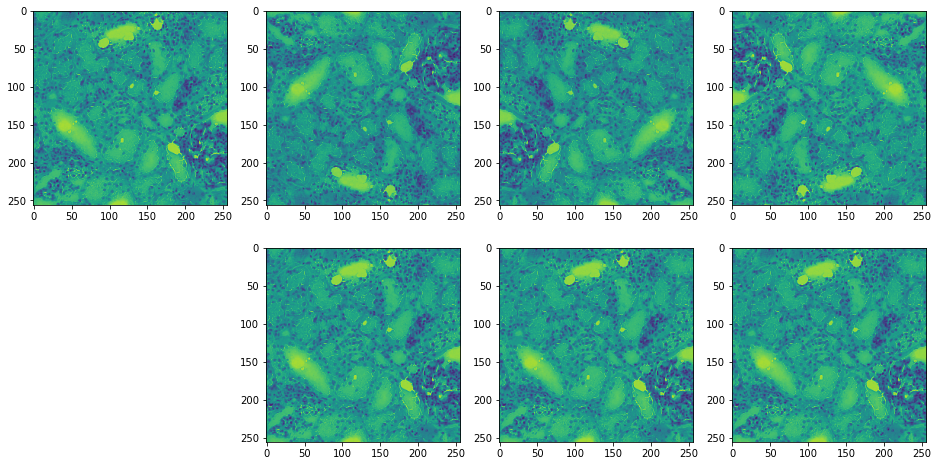

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(241)
plt.imshow(image[0]);

# flip1
plt.subplot(242)
image1 = torch.flip(image, [0, 1])
plt.imshow(image1[0])

plt.subplot(246)
image1 = torch.flip(image, [0, 1])
plt.imshow(torch.flip(image1, [1, 0])[0])

# flip2
plt.subplot(243)
image1 = torch.flip(image, [0, -1])
plt.imshow(image1[0])

plt.subplot(247)
image1 = torch.flip(image, [0, -1])
plt.imshow(torch.flip(image1, [-1, 0])[0])

# flip3
plt.subplot(244)
image1 = torch.flip(image, [1, -1])
plt.imshow(image1[0])

plt.subplot(248)
image1 = torch.flip(image, [1, -1])
plt.imshow(torch.flip(image1, [-1, 1])[0])

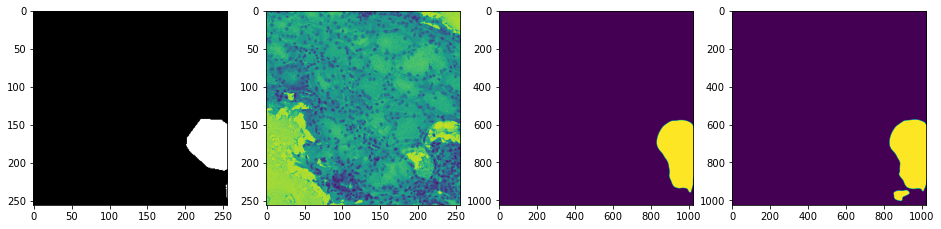

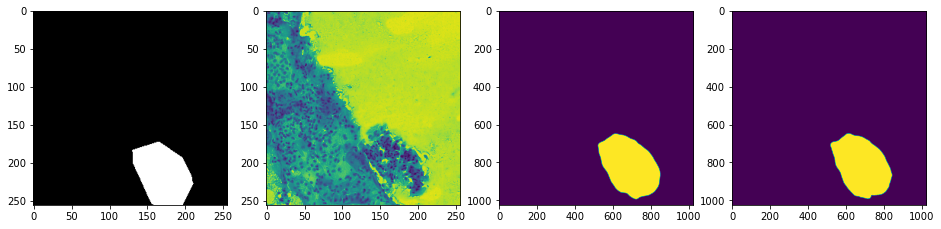

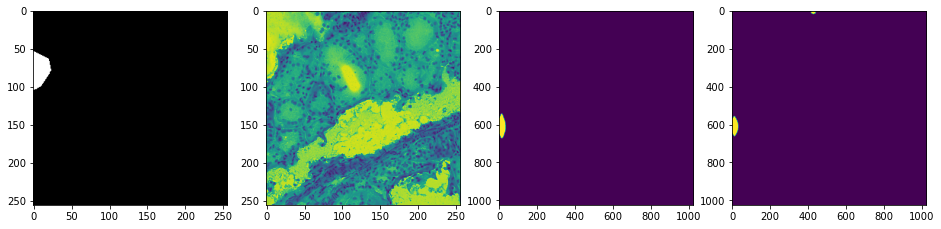

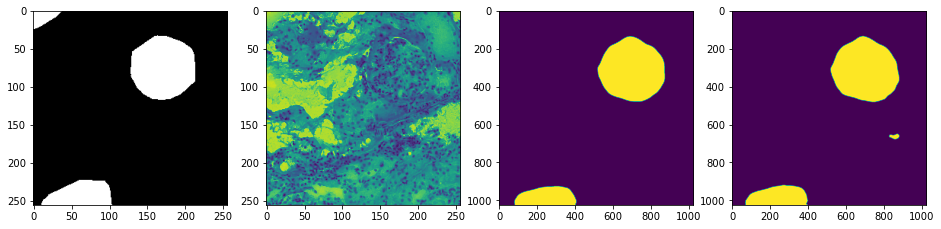

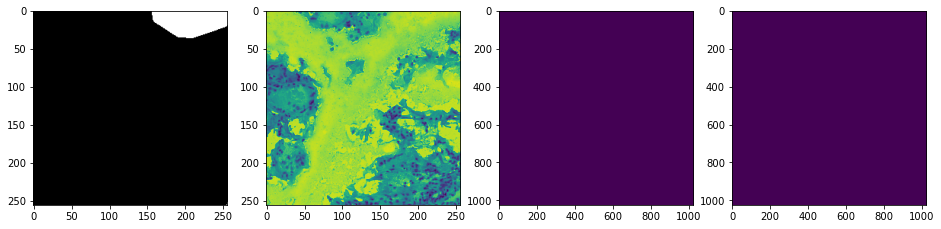

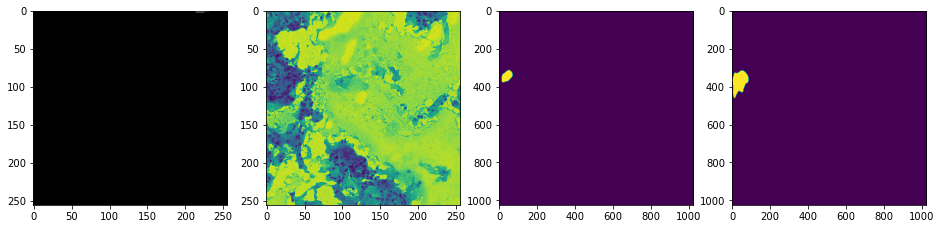

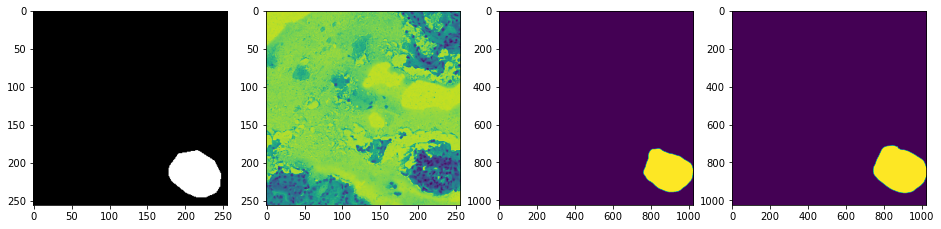

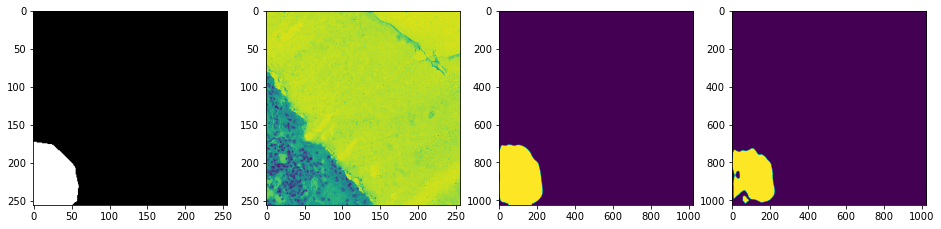

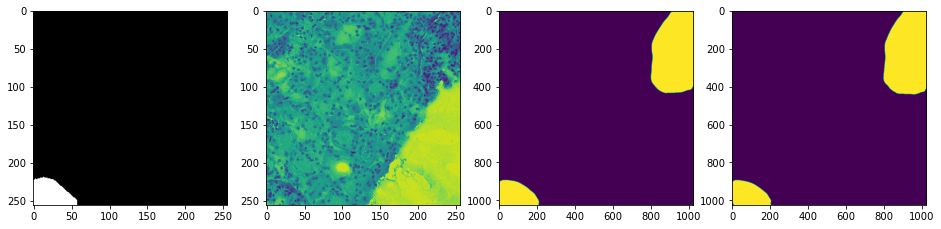

In [29]:
c = 1
for idx in range(80, 200):
    
    image, mask = valid_ds[idx]
    if mask.max() == 0:
        continue
    
    c += 1
    if c > 10:
        continue
    
    plt.figure(figsize=(16,8))
    plt.subplot(141)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(142)
    plt.imshow(image[0]);

    with torch.no_grad():
        image = image.to(DEVICE)[None]

        score = model(image)[0][0]

        score2 = model(torch.flip(image, [0, 3]))
        score2 = torch.flip(score2, [3, 0])[0][0]

        score3 = model(torch.flip(image, [1, 2]))
        score3 = torch.flip(score3, [2, 1])[0][0]


        score_mean = (score + score2 + score3) / 3.0

        score_sigmoid = score_mean.sigmoid().cpu().numpy()
        score_sigmoid = cv2.resize(score_sigmoid, (WINDOW, WINDOW))

        score = score.sigmoid().cpu().numpy()
        score = cv2.resize(score, (WINDOW, WINDOW))


    plt.subplot(143)
    plt.imshow((score_sigmoid > 0.5).astype(int));

    plt.subplot(144)
    plt.imshow((score > 0.5).astype(int));